In [1]:
from typing import List
import nltk
import string
import pymorphy2
import codecs

class PrepareNew():
  def __init__(self):
    self.morph = pymorphy2.MorphAnalyzer()
    self.tokenizer = nltk.WordPunctTokenizer()
    self.stopwords = set(line.strip() for line in codecs.open('../rus_stopwords.txt', "r", "utf_8_sig").readlines())

  def prepare_corp(self, news_list: List[str]):
    return [self.newstext2token(news_text) for news_text in news_list]

  def newstext2token(self, news_text: str):
      tokens = self.tokenizer.tokenize(news_text.lower())
      tokens_with_no_punct = [self.morph.parse(w)[0].normal_form for w in tokens if all(c not in string.punctuation for c in w)]
      tokens_base_forms = [w for w in tokens_with_no_punct if w not in self.stopwords and w.isalpha()]
      tokens_last = [w for w in tokens_base_forms if len(w)>1]
      return tokens_last


In [2]:
raw_data = [line.strip() for line in codecs.open('../emb_dataset_commersant.txt', "r", "utf_8_sig").readlines() if line.strip()!=""]

In [4]:
my_corp = PrepareNew().prepare_corp(raw_data)

In [5]:
from gensim.models import Word2Vec
from gensim.models import Phrases
bigram_transformer = Phrases(my_corp)
embeddings = Word2Vec(bigram_transformer[my_corp], window=5, min_count=2).wv

In [6]:
type(embeddings)

gensim.models.keyedvectors.KeyedVectors

In [7]:
embeddings.most_similar('рубль', topn=10)

[('компонент', 0.9901496767997742),
 ('вклад', 0.9899197816848755),
 ('падение_курс', 0.9896195530891418),
 ('конечный', 0.9879881739616394),
 ('чистый', 0.9868649244308472),
 ('продолжительность', 0.9863075017929077),
 ('минус', 0.9862525463104248),
 ('потребление', 0.9859995245933533),
 ('падать', 0.9857270121574402),
 ('доходность', 0.9848158359527588)]

In [8]:
from gensim.models import KeyedVectors
import numpy as np
def text2vec(tokens: List[str], embeddings: KeyedVectors, dim: int = 100) -> np.ndarray:
    """
        question: токены
        embeddings: w2v модель
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """

    relevant=0
    words_vecs=np.zeros((dim,))
    for word in tokens:
      if word in embeddings:
        words_vecs+=embeddings[word]
        relevant+=1

    if relevant:
      words_vecs/=relevant
    return words_vecs


In [9]:
import pandas as pd
df = pd.DataFrame()

print(len(raw_data), len(my_corp))

df['full_text'] = raw_data
df['tokens'] = my_corp

19598 19598


In [10]:
data_vectors = np.array([text2vec(tokens, embeddings) for tokens in my_corp])

In [11]:
data_vectors.shape

(19598, 100)

In [12]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_vectors)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19598 samples in 0.002s...
[t-SNE] Computed neighbors for 19598 samples in 8.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19598
[t-SNE] Computed conditional probabilities for sample 2000 / 19598
[t-SNE] Computed conditional probabilities for sample 3000 / 19598
[t-SNE] Computed conditional probabilities for sample 4000 / 19598
[t-SNE] Computed conditional probabilities for sample 5000 / 19598
[t-SNE] Computed conditional probabilities for sample 6000 / 19598
[t-SNE] Computed conditional probabilities for sample 7000 / 19598
[t-SNE] Computed conditional probabilities for sample 8000 / 19598
[t-SNE] Computed conditional probabilities for sample 9000 / 19598
[t-SNE] Computed conditional probabilities for sample 10000 / 19598
[t-SNE] Computed conditional probabilities for sample 11000 / 19598
[t-SNE] Computed conditional probabilities for sample 12000 / 19598
[t-SNE] Computed conditional probabilities for sa

In [13]:
df['x'] = tsne_results[:,0]
df['y'] = tsne_results[:,1]

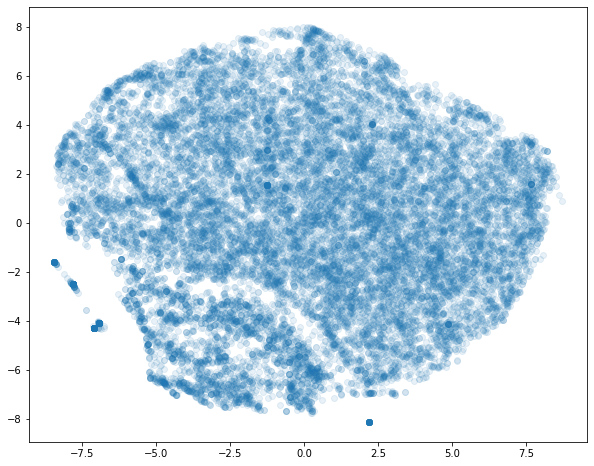

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1);

In [15]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = tsne_results
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.tokens.str.contains(pattern, regex=False)]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = tsne_results
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = tsne_results[label_indices, 0]
    Ylabeled = tsne_results[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax


def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

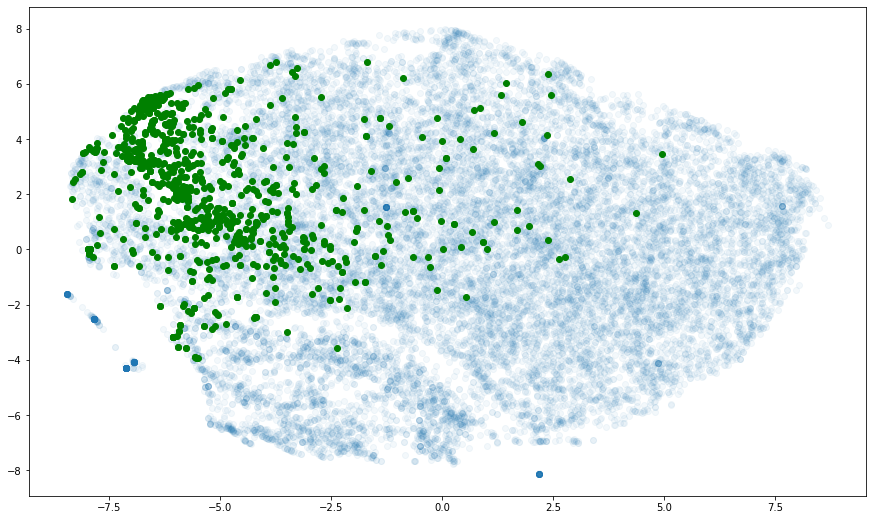

In [16]:
plot_by_title_pattern('инфляция', figsize=(15, 9), bg_alpha=.05, text=False);

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from typing import Tuple
def extract_keywords(tokens: List[str],
                     embeddings: KeyedVectors,
                     top_n: int = 5,
                     diversity: float = 0.5,
                     nr_candidates: int = 20) -> List[Tuple[str, float]]:
    
    # Extract Embeddings
    candidates = []
    doc_embedding = text2vec(tokens, embeddings).reshape(1, -1)
    candidate_embeddings = []
    for candidate in tokens:
        if candidate in embeddings:
            candidates.append(candidate)
            candidate_embeddings.append(embeddings[candidate])
            
    if len(candidates)==0:
        return tokens

    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [(candidates[index], round(float(distances[0][index]), 4))
                for index in distances.argsort()[0][-top_n:]][::-1]

    return keywords


In [18]:
print(extract_keywords(df.tokens[0], embeddings))

[('отпуск', 0.9953), ('развлечение', 0.9943), ('малое', 0.9904), ('увольнение', 0.9855), ('сотрудник', 0.9813)]


In [19]:
print(df.full_text[0])

Вечером в пятницу, 7 августа, правительство Италии одобрило очередной пакет мер по поддержке экономики на общую сумму €25 млрд. Он в числе прочего включает налоговые льготы для малого и среднего бизнеса, а также компаний, нанимающих сотрудников на юге Италии, продление единовременных выплат для работников сферы развлечений и туризма и выплат сотрудникам компаний, которым пришлось уйти в неоплачиваемые отпуска, выделение средств на здравоохранение. Кроме того, до конца года продлевается запрет на коллективные увольнения.


In [20]:
highlights_list = []
for tokens in df.tokens:
    keywords = list(set([keyword[0] for keyword in extract_keywords(tokens, embeddings)]))
    if keywords:
        highlights_list.append(', '.join(keywords))
    else:
        highlights_list.append(' ')

In [21]:
df['highlights'] = np.array(highlights_list)

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=11, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(data_vectors)
df['labels']=kmeans.labels_

In [30]:
label_dicta = df.labels.value_counts()
print(dict(label_dicta))

{2: 3106, 5: 2930, 8: 2928, 9: 2579, 0: 2082, 1: 1552, 4: 1278, 6: 1130, 3: 858, 7: 747, 10: 408}


In [23]:
df.to_csv("emb_vis_commersant_clustered.csv", sep = ';')